# **MAAS User Interface**

Este notebook detalla la interfaz a utilizar para ejecutar MAAS. Funciona en Google Colab y en JupyterLab.

## Consideraciones
### Instalar
- numpy
- IPython
- soundfile
- scipy
- matplotlib
- sounddevice
- ipython-autotime

### Si ejecuta en JupyterLab
- Le preguntará si gusta grabar desde el micrófono (presione ENTER); de no ser así, escriba el nombre de un archivo WAV a 44100 Hz (con extensión), colocado en ./samples/ y presione ENTER.
- Si cargó un archivo de audio, le preguntará si gusta guardar el CSV generado con MAAS_filter() en ./database/ para posteriores comparaciones.
- Si clonó el repositorio, funciona out of the box. Recuerde instalar toda la paquetería requerida y verificar que MAAS_Filters.ipynb se encuentre en el mismo directorio.

### Si ejecuta en Colab
- Puede utilizar el micrófono y grabar (si la sesión es nueva, puede que requiera de dos intentos por cuestiones de permisos).
- No se guardará ningún CSV.
- Debe cargar la base de datos a la raíz de la sesión (\[/content\]/*.csv) para realizar la comparación.
- Debe cargar el módulo MAAS_Filters.ipynb a la raíz de la sesión (\[/content\]/MAAS_Filters.ipynb).

## Autores
- Diego Casta - 35705
- Mauricio Alcántar - 35860
- David Santana - 35967

## **Librerías**

In [1]:
# Intentar cargar la librería de Google Colab.
try:
    from google.colab import output
except ImportError:
    pass

# Decidir si estamos en colab.
IN_COLAB = None
if 'google.colab' in str(get_ipython()):
  IN_COLAB = True
  print('Ejecutándose en Colab')
else:
  IN_COLAB = False
  print('Ejecutándose localmente')

# Si es así, instalar librerías automáticamente.
if IN_COLAB:
  !pip install ipython-autotime numpy IPython soundfile scipy matplotlib sounddevice

Ejecutándose localmente


In [2]:
# Cargar métrica de tiempo para las celdas
%load_ext autotime

time: 0 ns (started: 2024-12-02 15:04:43 -08:00)


In [3]:
# Importar librerías
import numpy as np
from base64 import b64decode
from IPython.display import Javascript
import IPython.display as ipd
import io
import soundfile as sf
from scipy import signal as sig
from scipy.io import wavfile as wav
from os import listdir
import sounddevice as sd
import matplotlib.pyplot as plt
import math

time: 1.01 s (started: 2024-12-02 15:04:43 -08:00)


## **Lectura de archivo**

In [4]:
# Código JavaScript para grabar desde el micrófono del navegador en Colab. Se ignora si el entorno no es Colab.
RECORD = None if not IN_COLAB else """
const sleep  = time => new Promise(resolve => setTimeout(resolve, time));

const b2text = blob => new Promise(resolve => {
  const reader = new FileReader();
  reader.onloadend = e => resolve(e.srcElement.result);
  reader.readAsDataURL(blob);
});

var record = time => new Promise(async resolve => {
  const stream = await navigator.mediaDevices.getUserMedia({ audio: true });
  const audioContext = new AudioContext({ sampleRate: 44100 });
  const source = audioContext.createMediaStreamSource(stream);
  const recorder = new MediaRecorder(stream);
  let chunks = [];

  recorder.ondataavailable = e => chunks.push(e.data);
  alert("Presiona 'aceptar' para empezar la grabación.");
  recorder.start();
  await sleep(time);

  recorder.onstop = async () => {
    const blob = new Blob(chunks, { type: 'audio/ogg; codecs=opus' });
    const arrayBuffer = await blob.arrayBuffer();
    const audioBuffer = await audioContext.decodeAudioData(arrayBuffer);

    // Convert to WAV format
    const wavBlob = encodeWAV(audioBuffer, 44100, 16);
    const wavText = await b2text(wavBlob);
    resolve(wavText);

    // Clean up
    stream.getTracks().forEach(track => track.stop());
    audioContext.close();
  };

  recorder.stop();
});

// WAV encoding function
function encodeWAV(audioBuffer, sampleRate, bitDepth) {
  const numChannels = audioBuffer.numberOfChannels;
  const length = audioBuffer.length * numChannels * (bitDepth / 8);
  const buffer = new ArrayBuffer(44 + length);
  const view = new DataView(buffer);

  // WAV header
  writeString(view, 0, 'RIFF');
  view.setUint32(4, 36 + length, true);
  writeString(view, 8, 'WAVE');
  writeString(view, 12, 'fmt ');
  view.setUint32(16, 16, true);  // Format chunk length
  view.setUint16(20, 1, true);   // PCM format
  view.setUint16(22, numChannels, true);
  view.setUint32(24, sampleRate, true);
  view.setUint32(28, sampleRate * numChannels * (bitDepth / 8), true); // Byte rate
  view.setUint16(32, numChannels * (bitDepth / 8), true); // Block align
  view.setUint16(34, bitDepth, true); // Bits per sample
  writeString(view, 36, 'data');
  view.setUint32(40, length, true);

  // Write PCM samples
  let offset = 44;
  for (let channel = 0; channel < numChannels; channel++) {
    const data = audioBuffer.getChannelData(channel);
    for (let i = 0; i < data.length; i++, offset += 2) {
      const sample = Math.max(-1, Math.min(1, data[i]));
      view.setInt16(offset, sample < 0 ? sample * 0x8000 : sample * 0x7FFF, true);
    }
  }

  return new Blob([view], { type: 'audio/wav' });
}

function writeString(view, offset, string) {
  for (let i = 0; i < string.length; i++) {
    view.setUint8(offset + i, string.charCodeAt(i));
  }
}
"""

# Función para grabar desde el micrófono local en JupyterLab. Retorna los datos y la tasa de muestreo.
def record_lab(duration=5, sample_rate=44100, channels=1):
    print("Grabando...")
    recording = sd.rec(int(duration * sample_rate), samplerate=sample_rate, channels=channels, dtype='int16')
    sd.wait()
    print("Grabación terminada.")
    return recording, sample_rate

# Función máscara para grabar en JupyterLab o Colab. Retorna un BytesIO con los datos del audio grabado.
def record(sec=10):
  if (IN_COLAB):
    output.eval_js(RECORD)
    sec += 1
    s = output.eval_js('record(%d)' % (sec*1000))
    print("Grabación terminada")
    return io.BytesIO(b64decode(s.split(',')[1]))
  else:
    recording, sample_rate = record_lab(duration=sec)
    byte_io = io.BytesIO()
    wav.write(byte_io, sample_rate, recording)
    byte_io.seek(0)
    return byte_io

time: 0 ns (started: 2024-12-02 15:04:44 -08:00)


In [5]:
FILENAME = '' if IN_COLAB else input("Presiona ENTER para grabar o introduce el nombre de un archivo WAV colocado en ./samples/")

Presiona ENTER para grabar o introduce el nombre de un archivo WAV colocado en ./samples/ wawasuerte.wav


time: 8.12 s (started: 2024-12-02 15:04:44 -08:00)


In [6]:
audio = record(10) if FILENAME == '' else open('./samples/' + FILENAME, 'rb') # Si no hay nombre de archivo, grabamos.

time: 0 ns (started: 2024-12-02 15:04:52 -08:00)


In [7]:
ipd.display(ipd.Audio(audio.read())) # Mostrar el audio a procesar.

time: 16 ms (started: 2024-12-02 15:04:52 -08:00)


In [8]:
audio.seek(0) # Retornar el cabezal del audio a 0.
data, sr = sf.read(audio) # Obtener de vuelta los datos y tasa de muestreo.
if (data.ndim == 2): data = data.mean(axis=1).astype(data.dtype) # Si hay dos canales, hacer mono.
print("La tasa de muestreo es {0}Hz".format(sr)) # Verificar tasa de muestreo.

La tasa de muestreo es 44100Hz
time: 0 ns (started: 2024-12-02 15:04:52 -08:00)


In [9]:
# Ejecutar la definición de MAAS_filter(), ubicada en el módulo MAAS_Filters.ipynb.
if (IN_COLAB):
  %run /content/MAAS_Filters.ipynb # En Colab, se busca en el directorio content (raíz).
else:
  %run ./MAAS_Filters.ipynb # En JupyterLab, se busca en el mismo directorio.

time: 172 ms (started: 2024-12-02 15:04:52 -08:00)


In [10]:
SHOULD_SAVE = False if IN_COLAB or FILENAME == '' else input('¿Guardar ./database/' + FILENAME[0:-3] + 'csv? [y/N]').lower() == 'y'

¿Guardar ./database/wawasuerte.csv? [y/N] n


time: 3.66 s (started: 2024-12-02 15:04:52 -08:00)


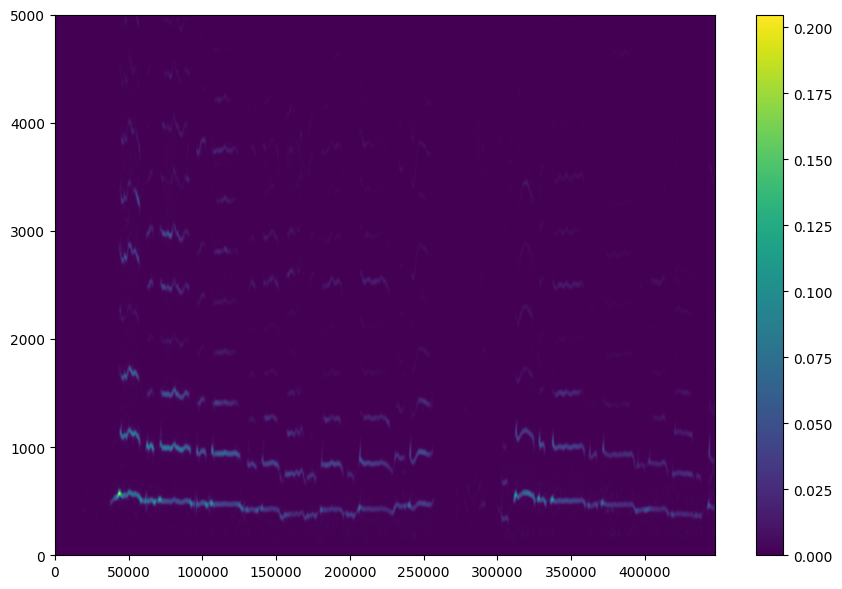

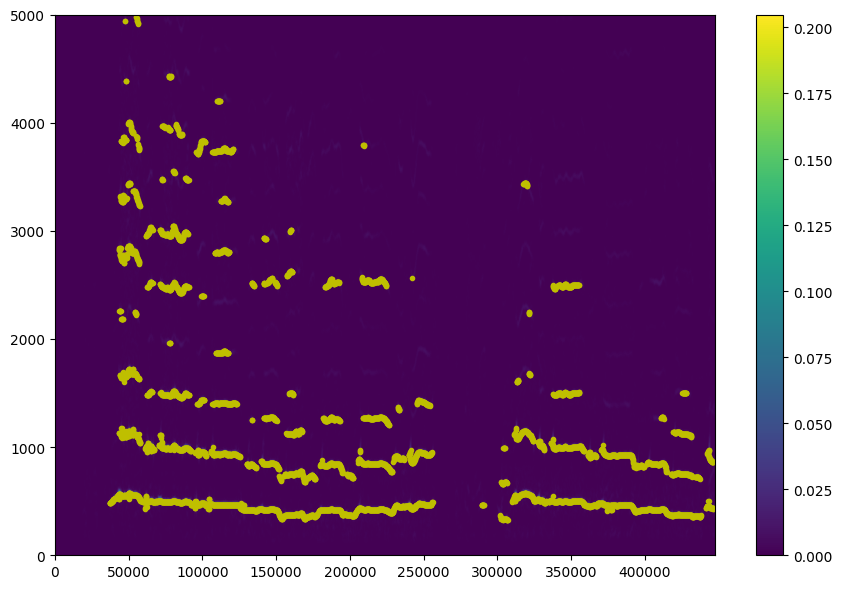

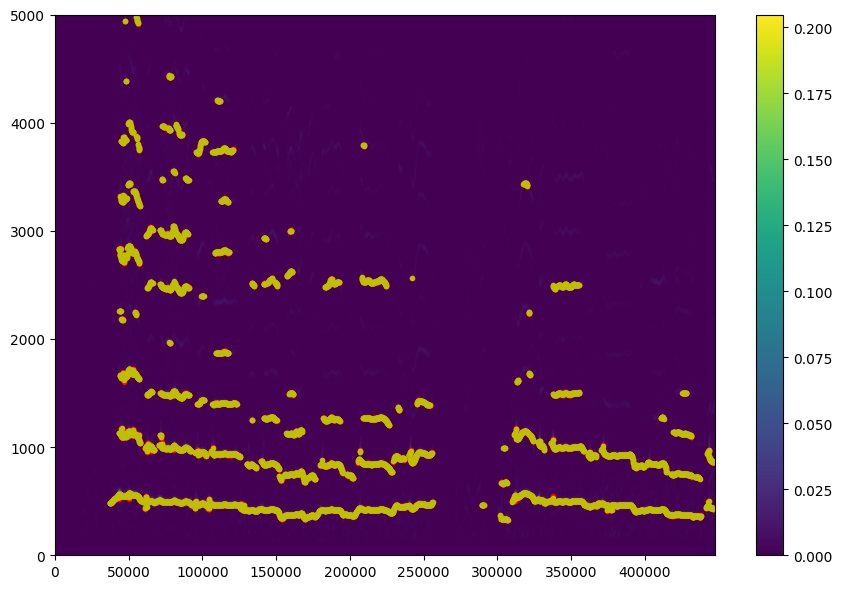

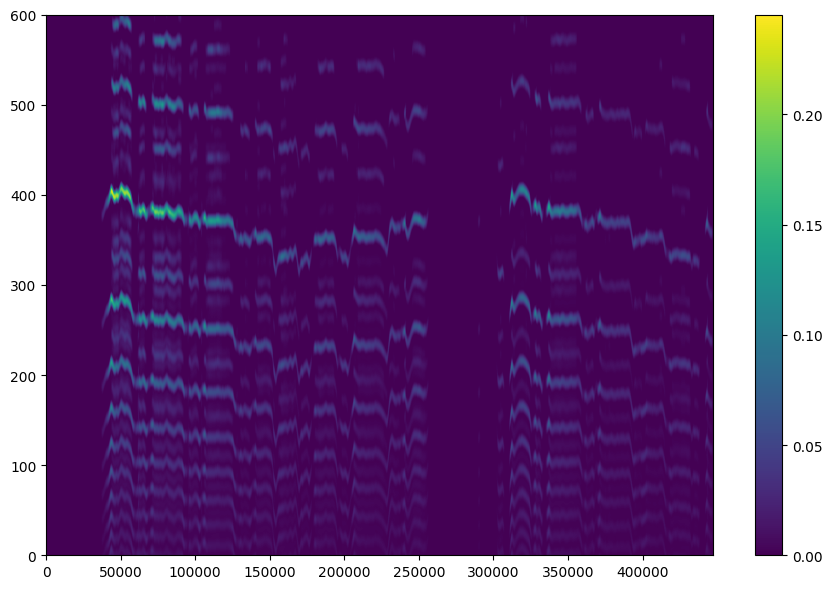

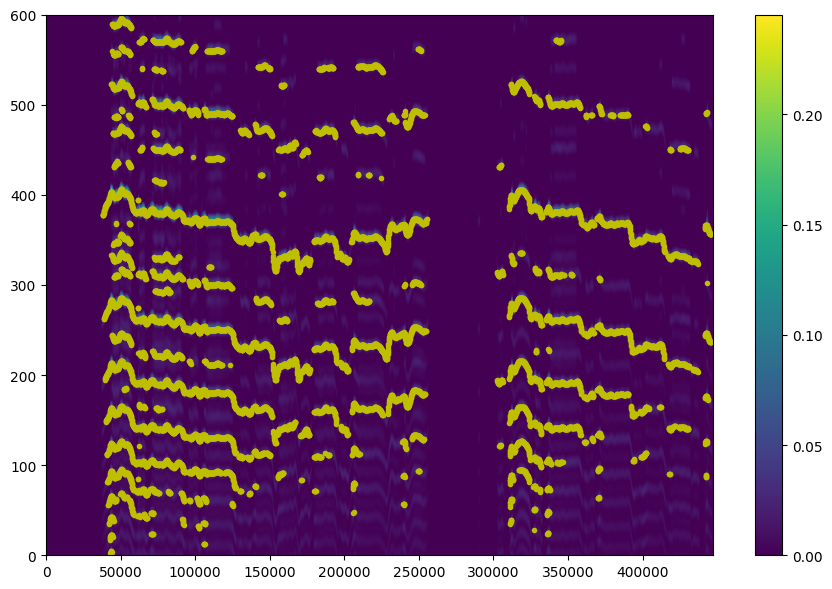

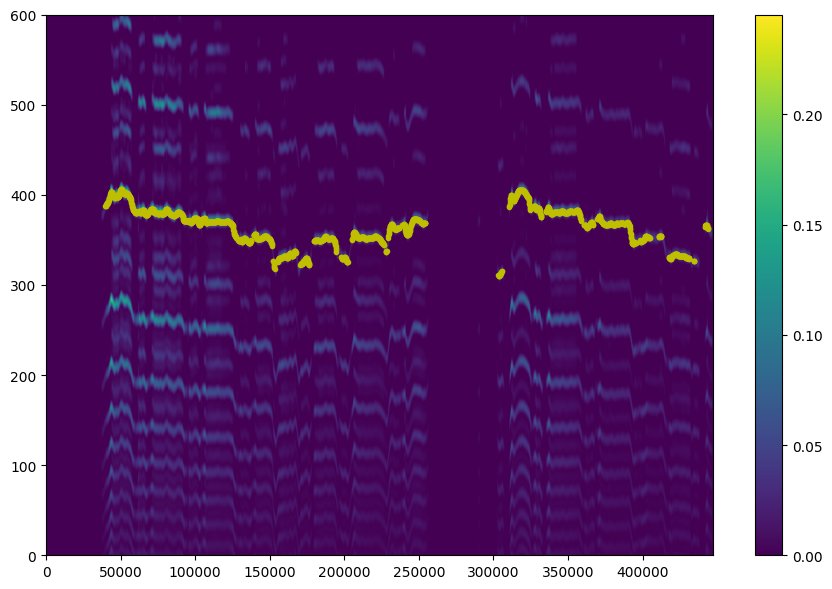

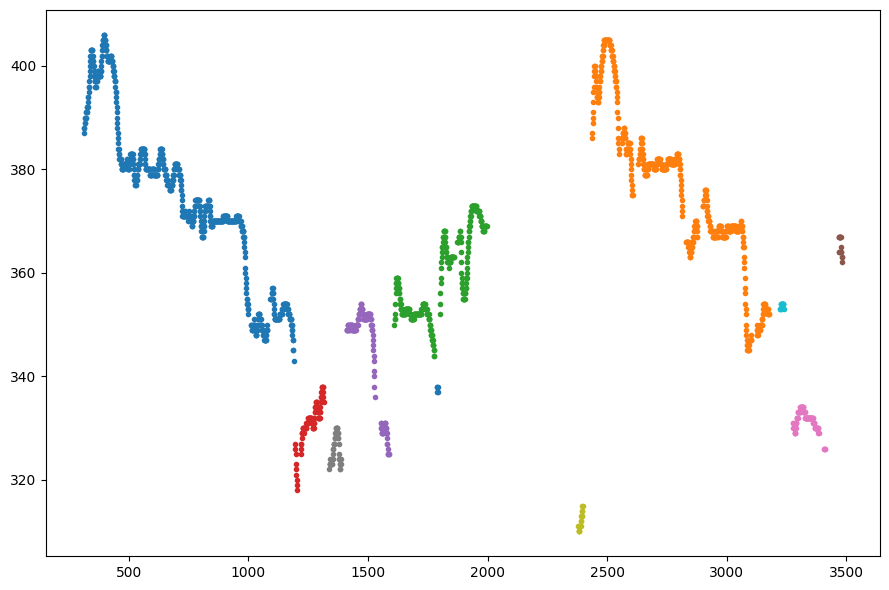

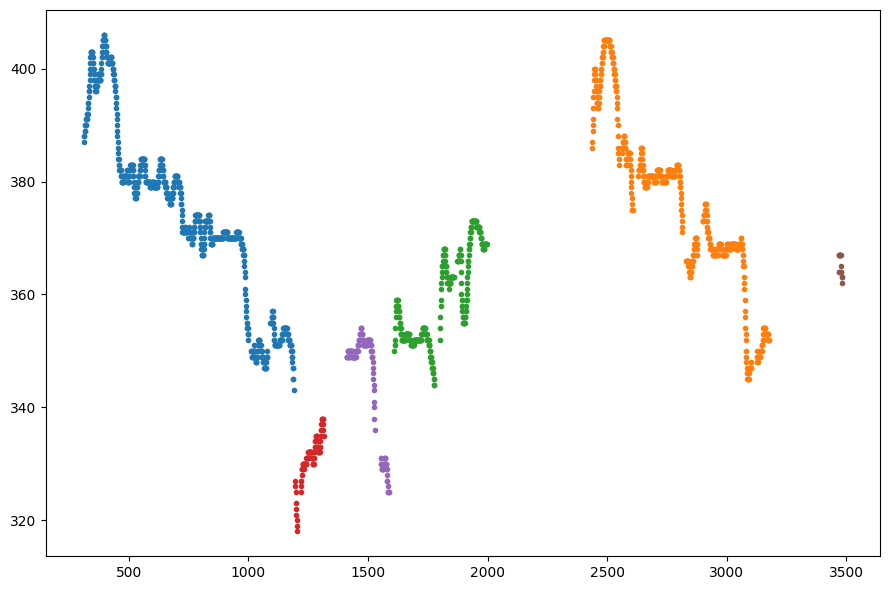

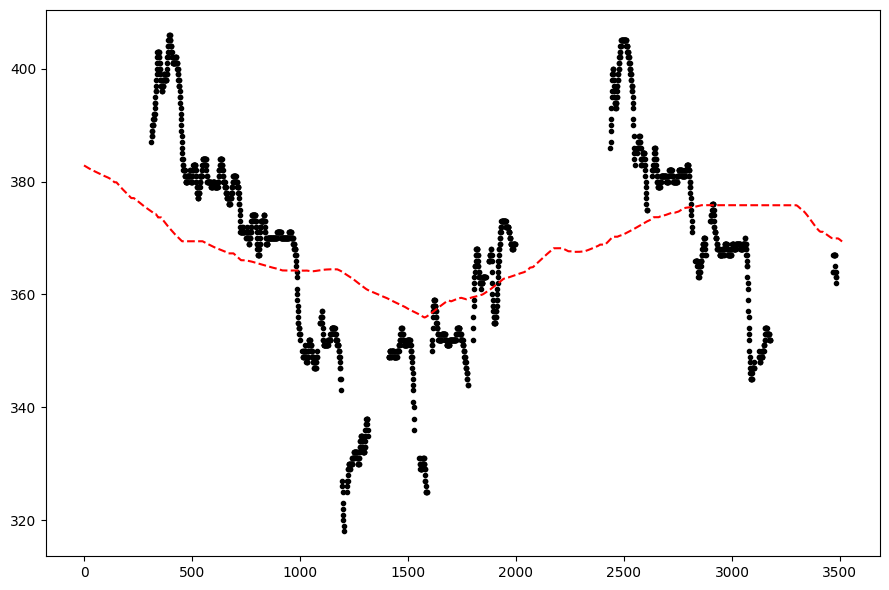

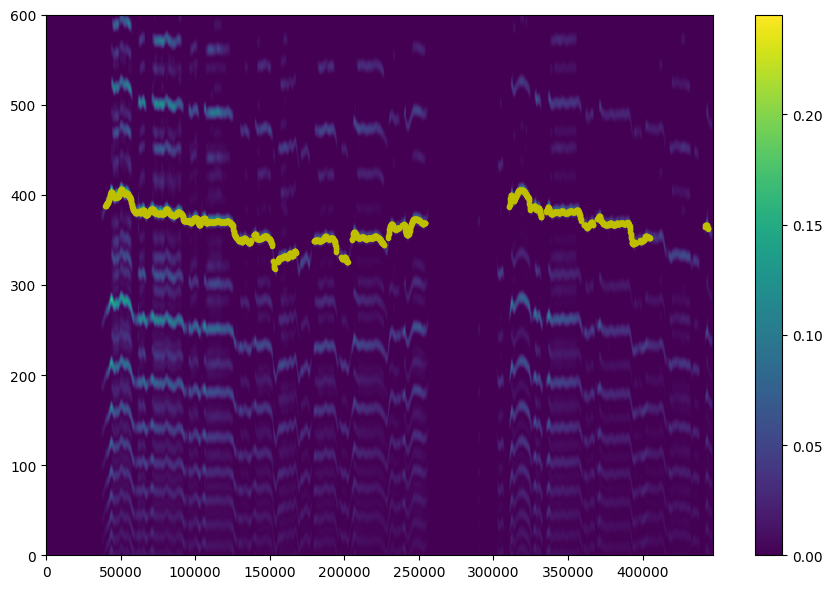

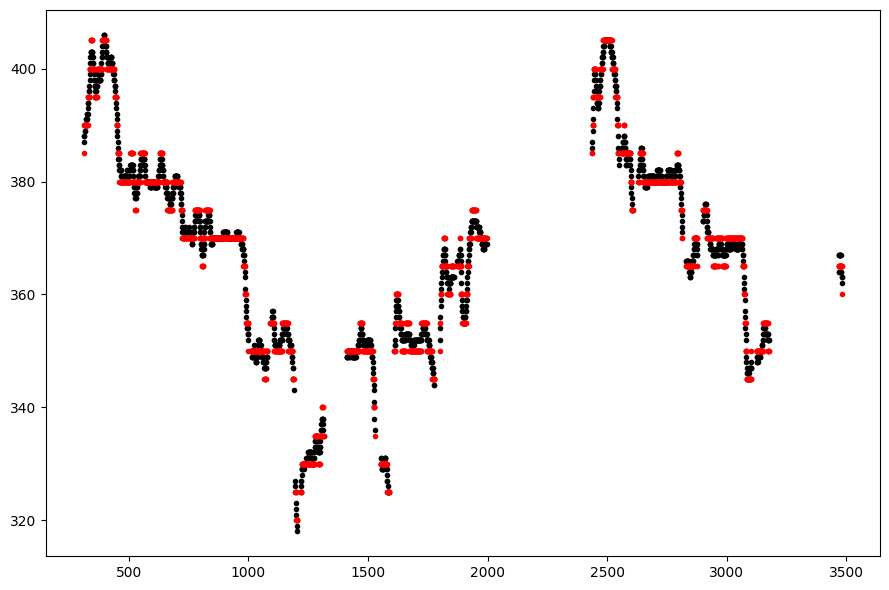

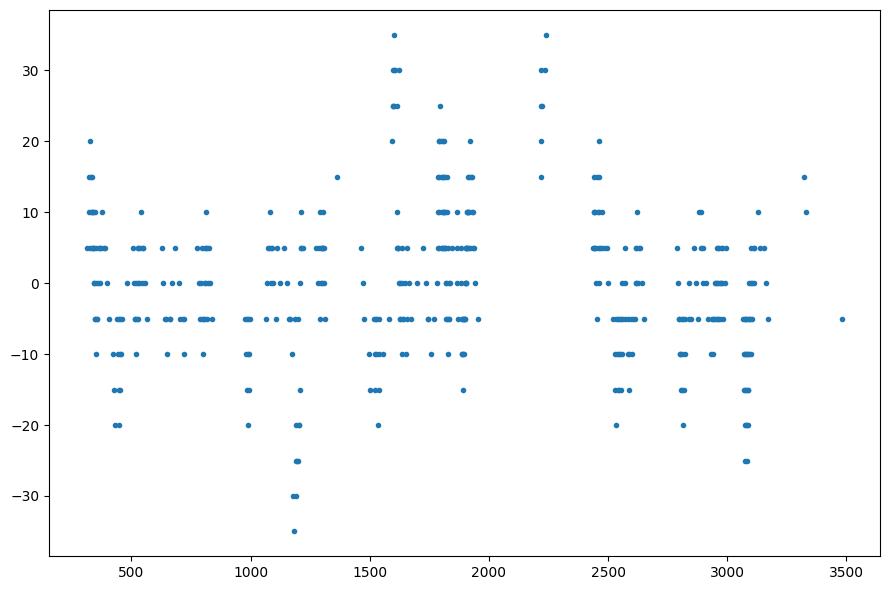

time: 37.7 s (started: 2024-12-02 15:04:56 -08:00)


In [11]:
filtered = MAAS_filter(data, sr, None if (not SHOULD_SAVE) else './database/' + FILENAME[0:-3] + 'csv') # Ejecutar filtros.

In [12]:
filtered, filtered.shape[1] # Mostrar datos filtrados.

(array([[ 312.5,  320. ,  323.5,  326. ,  329.5,  334. ,  327.5,  331. ,
          333.5,  337. ,  341.5,  347. ,  334.5,  337. ,  340.5,  345. ,
          350.5,  339.5,  343. ,  347.5,  353. ,  363.5,  346.5,  351. ,
          356.5,  367. ,  355.5,  361. ,  371.5,  366.5,  377. ,  386.5,
          387.5,  397. ,  406.5,  423. ,  427. ,  429.5,  439.5,  443.5,
          446. ,  449.5,  447.5,  450. ,  453.5,  452.5,  456. ,  459.5,
          482.5,  505.5,  510.5,  515.5,  517.5,  526.5,  515.5,  520.5,
          522.5,  531.5,  525.5,  527.5,  536.5,  546. ,  529.5,  538.5,
          548. ,  547.5,  557. ,  566.5,  627.5,  634. ,  644. ,  640.5,
          650.5,  661. ,  660.5,  671. ,  681.5,  699. ,  702. ,  716.5,
          719.5,  722.5,  774.5,  785.5,  789.5,  792.5,  796.5,  796.5,
          800.5,  803.5,  807.5,  817. ,  804.5,  807.5,  811.5,  821. ,
          810.5,  814.5,  824. ,  818.5,  828. ,  837.5,  978.5,  982. ,
          984. ,  989. ,  985.5,  987.5,  992.5,  9

time: 0 ns (started: 2024-12-02 15:05:34 -08:00)


In [13]:
# Función para ejecutar una regresión lineal sobre los pares de tiempo e intervalos.
def LinearRegressionMAAS(x, y, details=False):
    n = x.size
    xS = sum(x)
    yS = sum(y)
    x2 = sum(x**2)
    y2 = sum(y**2)
    xy = sum(x*y)
    
    # Cálculo de coeficientes
    a1 = ((n*xy) - (xS*yS)) / ((n*x2) - (xS**2))
    a0 = np.mean(y) - (a1 * np.mean(x))

    # Ajuste lineal
    f = a0 + (a1 * x)

    # Métrica de R^2
    RSS = sum((y - f)**2)
    TSS = sum((y - np.mean(y))**2)
    R2 = 0
    if TSS: R2 = 1 - (RSS / TSS)

    # Graficación
    if details:
        plt.plot(x, f, 'bo-')
        plt.plot(x ,y , 'ko')
        plt.title("Window")
        plt.show()
        print(f"y = {a0:.4f} + {a1:.4f}x")
    print(f"R² = {R2:.6f}")
    
    return R2

time: 0 ns (started: 2024-12-02 15:05:34 -08:00)


In [14]:
# Función para analizar ventana por ventana
def SlidingWindowRegression(recording_song, test_song, step, silent=True):
    rec_times, rec_intervals = recording_song[0], recording_song[1]
    test_times, test_intervals = test_song[0], test_song[1]
    window_size = rec_times[-1] - rec_times[0]
    step_size = np.floor(window_size / step)
    R2_arr = np.zeros(0)
    count = 0

    window_start = 0
    window_stop = 0
    while window_stop < test_times[-1]:
        window_stop = window_start + window_size
        window_mask = (test_times >= window_start) & (test_times <= window_stop)
        cur_times = test_times[window_mask]
        cur_intervals = test_intervals[window_mask]

        rec_pairs = np.zeros(0)
        test_pairs = np.zeros(0)
        for i in range(rec_times.size):
            inter_mask = abs(cur_intervals - rec_intervals[i]) <= 5
            inter_mask = inter_mask & (abs(cur_intervals - rec_intervals[i]) >= 5)
            new_pairs = cur_times[inter_mask]
            test_pairs = np.append(test_pairs, new_pairs)
            rec_pairs = np.append(rec_pairs, [rec_intervals[i]]*new_pairs.size)

        count += 1
        window_start += step_size

        if test_pairs.size:
            R2 = LinearRegressionMAAS(rec_pairs, test_pairs, details=not silent)
            R2_arr = np.append(R2_arr, R2)
            if not silent: print(f'Window {count} done successfully.')
        else:
            if not silent: print(f'Window {count} done, no pairs found.')
    
    if R2_arr.size:
        
        return max(R2_arr[R2_arr != 1.0])
    else:
        if not silent: print("Zero matches.\n")
        return 0

time: 0 ns (started: 2024-12-02 15:05:34 -08:00)


In [15]:
# Función para obtener todos los CSVs del directorio de la base de datos.
def get_database():
    filenames = listdir("/content/" if IN_COLAB else "./database/")
    return [ filename for filename in filenames if filename.endswith(".csv") ]

time: 0 ns (started: 2024-12-02 15:05:34 -08:00)


In [16]:
# Función para comparar dos audios filtrados.
def compare(filtered_song, db_obj, silent=True):
    test_song = np.transpose(np.genfromtxt(("/content/" if IN_COLAB else "./database/") + db_obj, delimiter=",", skip_header=1))

    print("Testing against:", db_obj)
    
    R2 = SlidingWindowRegression(filtered_song, test_song, 3, silent=silent)
    
    if R2:
        print("Best R²:", R2)
    else:
        if not silent: print(f"Zero correlation found for {db_obj}.")
    return R2

time: 16 ms (started: 2024-12-02 15:05:34 -08:00)


In [17]:
database = get_database() # Obtener la base de datos.
results = {} # Objeto para almacenar resultados.
for SONG in database: # Para cada canción de la base de datos...
    results[SONG] = compare(filtered, SONG) # ... comparar con el audio filtrado.

identified_song = max(results, key=results.get)[0:-4]
identified_song_name = ' '.join([str.capitalize() for str in identified_song.split('_')])
# Imprimir resultado.
print(f"La canción identificada fue {identified_song_name}")

Testing against: bloody_mary.csv
R² = 0.001320
R² = 0.001320
R² = 0.038305
R² = 0.075146
R² = 0.000224
R² = 0.004477
R² = 0.002417
R² = 0.001595
R² = 0.001599
R² = 0.000731
R² = 0.000172
R² = 0.006115
R² = 0.009358
R² = 0.012826
R² = 0.002316
R² = 0.000658
R² = 0.004414
R² = 0.000030
R² = 0.001443
R² = 0.000294
R² = 0.015053
R² = 0.014965
R² = 0.000084
R² = 0.010508
R² = 0.035148
R² = 0.300580
R² = 0.178569
R² = 0.083906
R² = 0.000116
R² = 0.012588
R² = 0.001123
R² = 0.000025
R² = 0.000054
R² = 0.001300
R² = 0.000641
R² = 0.004957
R² = 0.000078
R² = 0.000395
R² = 0.000034
R² = 0.000394
R² = 0.000010
R² = 0.007355
R² = 0.004048
R² = 0.000507
R² = 0.001712
R² = 0.053598
R² = 0.037323
R² = 0.179673
R² = 0.007243
R² = 0.007740
R² = 0.000011
R² = 0.041800
R² = 0.153072
R² = 0.006982
R² = 0.000183
R² = 0.000115
R² = 0.005348
R² = 0.004025
R² = 0.001630
R² = 0.002914
R² = 0.004871
R² = 0.001385
R² = 0.001986
R² = 0.006247
R² = 0.000517
R² = 0.001063
R² = 0.022151
R² = 0.012905
R² = 0.006527
R